# Numerical Integration and Differentiation

This notebook illustrates how to perform numerical integration and differentiation. 

There are several packages for doing this. Here, the focus is on [QuadGK](https://github.com/JuliaMath/QuadGK.jl) and [ForwardDiff](https://github.com/JuliaDiff/ForwardDiff.jl).

## Load Packages and Extra Functions

In [1]:
using Printf, QuadGK, ForwardDiff

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# Numerical Integration

As a simple illustration, the next cells plot and integrate the $N(0,\sigma)$ pdf.

## The Pdf of the N() Distribution 

Notice: the function takes $\mu$ and $\sigma$ (not $\sigma^2$) as inputs, similar to the Distributions package. 

In [3]:
function ϕNS(x,μ=0,σ=1)       #pdf of N(μ,σ), defaults to N(0,1)
    z   = (x - μ)/σ
    pdf = exp(-0.5*z^2)/(sqrt(2*pi)*σ)
    return pdf
end

ϕNS (generic function with 3 methods)

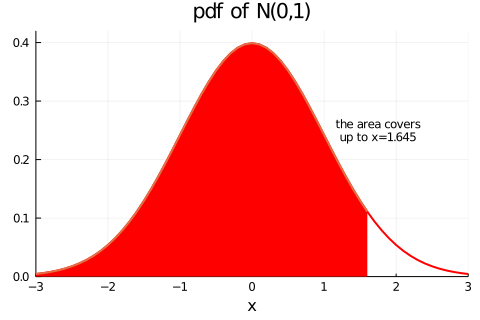

In [4]:
x  = -3:0.1:3
xb = x[x.<=1.645]

p1 = plot( x,ϕNS.(x),
           linecolor = :red,
           linewidth = 2,
           ylims = (0,0.42),
           xlims = (-3,3),
           legend = nothing,
           title = "pdf of N(0,1)",
           xlabel = "x",
           ylabel = "",
           annotation = (1.75,0.25,text("the area covers\nup to x=1.645",8)) )
plot!(xb,ϕNS.(xb),fillcolor=:red,linewidth=2,legend=nothing,fill=(0,:red))
display(p1)

## Calculating Prob(x<=1.645)

The next cell calculates (by numeric integration)

$\int_{-\infty}^{1.645}\phi(x,0,\sigma)dx$,

where $\phi(x,\mu,\sigma)$ is the pdf of an $N(\mu,\sigma)$ variable.


The input to `quadgk` should be a function with only one argument. We do that by creating an anonymous function
```
x->fn(x,a)
```
assuming that `a` has a value already.

In [5]:
cdf1, = quadgk(x->ϕNS(x),-Inf,1.645)       #N(0,1)
printlnPs("\nPr(x<=1.64) according to N(0,1):", cdf1)

cdf2, = quadgk(x->ϕNS(x,0,2),-Inf,1.645)   #N(0,σ=2)
printlnPs("\nPr(x<=1.64) according to N(0,2):", cdf2)


Pr(x<=1.64) according to N(0,1):     0.950

Pr(x<=1.64) according to N(0,2):     0.795


# Numerical Derivatives

Numerical derivatives can be calculated by a crude finite difference (see `NumDer()` below) or by the much more sophisticated routines in the `ForwardDiff` package.

To do this calculation for many `x` values, we loop (either a `for` loop or list comprehension). Dot syntax, `ForwardDiff.derivative.()`, seems to work, but is not documented.

In [6]:
function NumDer(fun,b0,h)     #crude function for a centered numerical derivative
    bminus = b0 .- h
    bplus  = b0 .+ h
    hh     = bplus - bminus
    fplus  = fun(bplus)
    fminus = fun(bminus)
    D      = (fplus-fminus)/hh
    return D
end

NumDer (generic function with 1 method)

In [7]:
function fn1(x,a)                 #a simple function, to be differentiated
   return (x - 1.1)^2 - a
end

fn1 (generic function with 1 method)

In [8]:
x0 = 2

dydx_A = NumDer(x->fn1(x,0.5),x0,0.01)           #differentiate fn1(x,0.5) at x = x0
dydx_B = ForwardDiff.derivative(x->fn1(x,0.5),x0)

println("The derivative at x=$x0 is (from two different methods): ")
printmat([dydx_A dydx_B])

The derivative at x=2 is (from two different methods): 
     1.800     1.800



In [9]:
x = -3:6/99:6          #calculate the derivative at many points

dydx_A = [NumDer(x->fn1(x,0.5),x[i],0.01) for i=1:length(x)]  #list comprehension as a quick loop

dydx_B = [ForwardDiff.derivative(x->fn1(x,0.5),x[i]) for i=1:length(x)]

println("now lets plot this")

now lets plot this


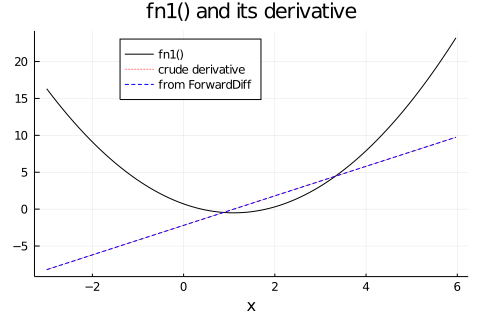

In [10]:
p1 = plot( [x x x],[fn1.(x,0.5) dydx_A dydx_B],
           line = [:solid :dot :dash],
           linecolor = [:black :red :blue],
           label = ["fn1()" "crude derivative" "from ForwardDiff"],
           legend = :top,
           title = "fn1() and its derivative",
           xlabel = "x",
           ylabel = "" )
display(p1)

## Comments on Using the ForwardDiff Package (extra)

The `ForwardDiff` package applies an interesting approach to calculate derivatives, using a special number type ("dual numbers"). This means that your code must be able to handle such numbers. In most cases, that is not a problem, but you may have to watch out if you create arrays to store (intermediate?) results inside the function. See the examples below

In [11]:
function fnDoesNotWork(b,a)
    z = zeros(length(b))              #will not work with ForwardDiff, since
    for i = 1:length(z)               #z cannot store dual numbers
        z[i] = b[i]*i
    end
    return sum(z) + a
end

function fnDoesWork(b,a)
    z = zeros(eltype(b),length(b))   #will work with ForwardDiff, since
    for i = 1:length(z)              #when b is a dual number, so is z 
        z[i] = b[i]*i                #could also start with z = similar(b)
    end
    return sum(z) + a
end

fnDoesWork (generic function with 1 method)

In [12]:
b0 = [1.5,2]

#ForwardDiff.gradient(b->fnDoesNotWork(b,1),b0)      #uncomment to get an error
ForwardDiff.gradient(b->fnDoesWork(b,1),b0)

2-element Vector{Float64}:
 1.0
 2.0